In [2]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
import pandas as pd

In [3]:
train = pd.read_csv('../data/train_with_desc_full.csv', dtype={'tipodepropiedad':'category', 'ciudad':'category', 'provincia':'category', 'id':'int32', 'antiguedad':'float16', 'habitaciones':'float16', 'garages':'float16', 'banos':'float16', 'metroscubiertos':'float16', 'metrostotales':'float16', 'idzona':'float16', 'lat':'float16', 'lng':'float16', 'gimnasio':'bool', 'usosmultiples':'bool', 'piscina':'bool', 'escuelascercanas':'bool', 'centroscomercialescercanos':'bool'}, parse_dates=['fecha'])
test = pd.read_csv('../data/test_with_desc_full.csv', dtype={'tipodepropiedad':'category', 'ciudad':'category', 'provincia':'category', 'id':'int32', 'antiguedad':'float16', 'habitaciones':'float16', 'garages':'float16', 'banos':'float16', 'metroscubiertos':'float16', 'metrostotales':'float16', 'idzona':'float16', 'lat':'float16', 'lng':'float16', 'gimnasio':'bool', 'usosmultiples':'bool', 'piscina':'bool', 'escuelascercanas':'bool', 'centroscomercialescercanos':'bool'}, parse_dates=['fecha'])

In [4]:
rescued_coords = pd.read_csv('../data/rescueLatLongs.csv')
rescued_antiguedad = pd.read_csv('../data/imputations/antiguedad.csv')
rescued_banos = pd.read_csv('../data/imputations/banos.csv')
rescued_garages = pd.read_csv('../data/imputations/garages.csv')
rescued_habitaciones = pd.read_csv('../data/imputations/habitaciones.csv')
rescued_metroscubiertos = pd.read_csv('../data/imputations/metroscubiertos.csv')
rescued_metrostotales = pd.read_csv('../data/imputations/metrostotales.csv')

In [5]:
# mergeamos con coords. extra obtenidas en tp1.
train = train.merge(rescued_coords.drop('Unnamed: 0', axis=1), how='left', on='id')
train['lat_x'] = train.apply(lambda x: x['lat_y'] if pd.isna(x['lat_x']) else x['lat_x'], axis=1)
train['lng_x'] = train.apply(lambda x: x['lng_y'] if pd.isna(x['lng_x']) else x['lng_x'], axis=1)
train.drop(['lat_y','lng_y'], axis=1, inplace=True)
train.rename(columns={'lat_x':'lat','lng_x':'lon'}, inplace=True)

# por consistencia, para que ambos datasets tengan mismos nombres
test.rename(columns={'lng':'lon'}, inplace=True)
train.head()

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,...,cerca_o_en_avenida,comercial,tiene_servicio,edificio,casa,parte_de_lote,calle_cerrada,indica_frente_y_fondo,usa_easybroker,tiene_seguridad
0,254099,depto. tipo a-402,"depto. interior de 80.15m2, consta de sala com...",Apartamento,Avenida Division del Norte 2005,Benito Juárez,Distrito Federal,NaN,2.0,1.0,...,False,False,False,False,False,False,False,False,False,False
1,53461,condominio horizontal en venta,"<p>entre sonora y guerrero, atr&aacute;s del h...",Casa en condominio,AV. MEXICO,La Magdalena Contreras,Distrito Federal,10.0,3.0,2.0,...,False,False,True,False,True,False,False,False,False,False
2,247984,casa en venta urbi 3 recamaras tonala,descripcion \nla mejor ubicacion residencial e...,Casa,Urbi Tonala,Tonalá,Jalisco,5.0,3.0,2.0,...,False,True,True,False,True,False,False,False,False,True
3,209067,casa sola en toluca zinacantepec con credito i...,casa en privada con caseta de vigilancia casas...,Casa,IGNACIO MANUEL ALTAMIRANO 128,Zinacantepec,Edo. de México,1.0,2.0,1.0,...,False,True,False,False,True,False,False,False,False,True
4,185997,paseos del sol,bonito departamento en excelentes condiciones ...,Apartamento,PASEOS DEL SOL,Zapopan,Jalisco,10.0,2.0,1.0,...,False,False,False,False,False,False,False,False,False,False


In [6]:
# Nan para los datos fuera de rango es mejor que dropear todo el dato
train.loc[(train['lat']>14) | (train['lat']<33),['lat','lon']] = np.nan
train.loc[(train['lon']>86) | (train['lon']<118),['lat','lon']] = np.nan

In [7]:
# inf. values don't make sense. I think it's preferable to treat them as nans directly.
train.replace([np.inf, -np.inf], np.nan, inplace=True)

In [8]:
test.loc[(train['lat']>14) | (train['lat']<33),['lat','lon']] = np.nan
test.loc[(train['lon']>86) | (train['lon']<118),['lat','lon']] = np.nan

In [9]:
test.replace([np.inf, -np.inf], np.nan, inplace=True)

In [10]:
def fillna_with_models_predictions(df, predictions_df, col_name):
    indicadora_name = "tiene_" + col_name
    df[indicadora_name] = df[col_name].notna()
    
    df = df.merge(predictions_df, how='left', on='id')
    original_col = col_name + "_x"
    filler_col = col_name + "_y"
    df[col_name] = df.apply(lambda x: x[filler_col] if pd.isna(x[original_col]) else x[original_col], axis=1)
    df.drop([original_col,filler_col], axis=1, inplace=True)
    
    return df

In [11]:
def fill_na_values(df):
    df = fillna_with_models_predictions(df, rescued_antiguedad, 'antiguedad')
    df = fillna_with_models_predictions(df, rescued_banos, 'banos')
    df = fillna_with_models_predictions(df, rescued_garages, 'garages')
    df = fillna_with_models_predictions(df, rescued_habitaciones, 'habitaciones')
    df = fillna_with_models_predictions(df, rescued_metroscubiertos, 'metroscubiertos')
    df = fillna_with_models_predictions(df, rescued_metrostotales, 'metrostotales')
    return df

In [12]:
from multiprocessing import  Pool

def parallelize_dataframe(df, func, n_cores):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [13]:
train = parallelize_dataframe(train, fill_na_values, 8)
test = parallelize_dataframe(test, fill_na_values, 8)

# Agregamos features que ya hemos creado para analisis de tp1

In [14]:
def contar_amenities(row):
    return row['gimnasio'] + row['usosmultiples'] + row['piscina'] + row['escuelascercanas'] + row['centroscomercialescercanos']

In [15]:
train['cant_amenities'] = train.apply(lambda x: contar_amenities(x), axis=1)
test['cant_amenities'] = test.apply(lambda x: contar_amenities(x), axis=1)

In [16]:
def feature_fechas(df):
    # Para entender lo de los senos y cosenos: https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
    df['year'] = df['fecha'].dt.year
    df['month'] = df['fecha'].dt.month
    df['day'] = df['fecha'].dt.day
    df['sin_month'] = np.sin(2*np.pi*df['month']/12)
    df['cos_month'] = np.cos(2*np.pi*df['month']/12)
    # tomo cant. de dias en mes: 31 en todos los casos. Para esto deberia servir bastante bien igual.
    df['sin_day'] = np.sin(2*np.pi*df['day']/31)
    df['cos_day'] = np.cos(2*np.pi*df['day']/31)
    
    # no necesito mas las cols. originales de month y day.
    df.drop(['month','day'], axis=1, inplace=True)
    
feature_fechas(train)
feature_fechas(test)

In [17]:
palabras_avenida = ['avenida', 'av']
train['es_avenida'] = train['direccion'].fillna('no info').apply(lambda x: any(avenida_indicator in x.lower() for avenida_indicator in palabras_avenida))
test['es_avenida'] = test['direccion'].fillna('no info').apply(lambda x: any(avenida_indicator in x.lower() for avenida_indicator in palabras_avenida))

# * Fin agregado de features de tp1 *

## Diferentes metodos de seleccion

### Matriz de correlacion

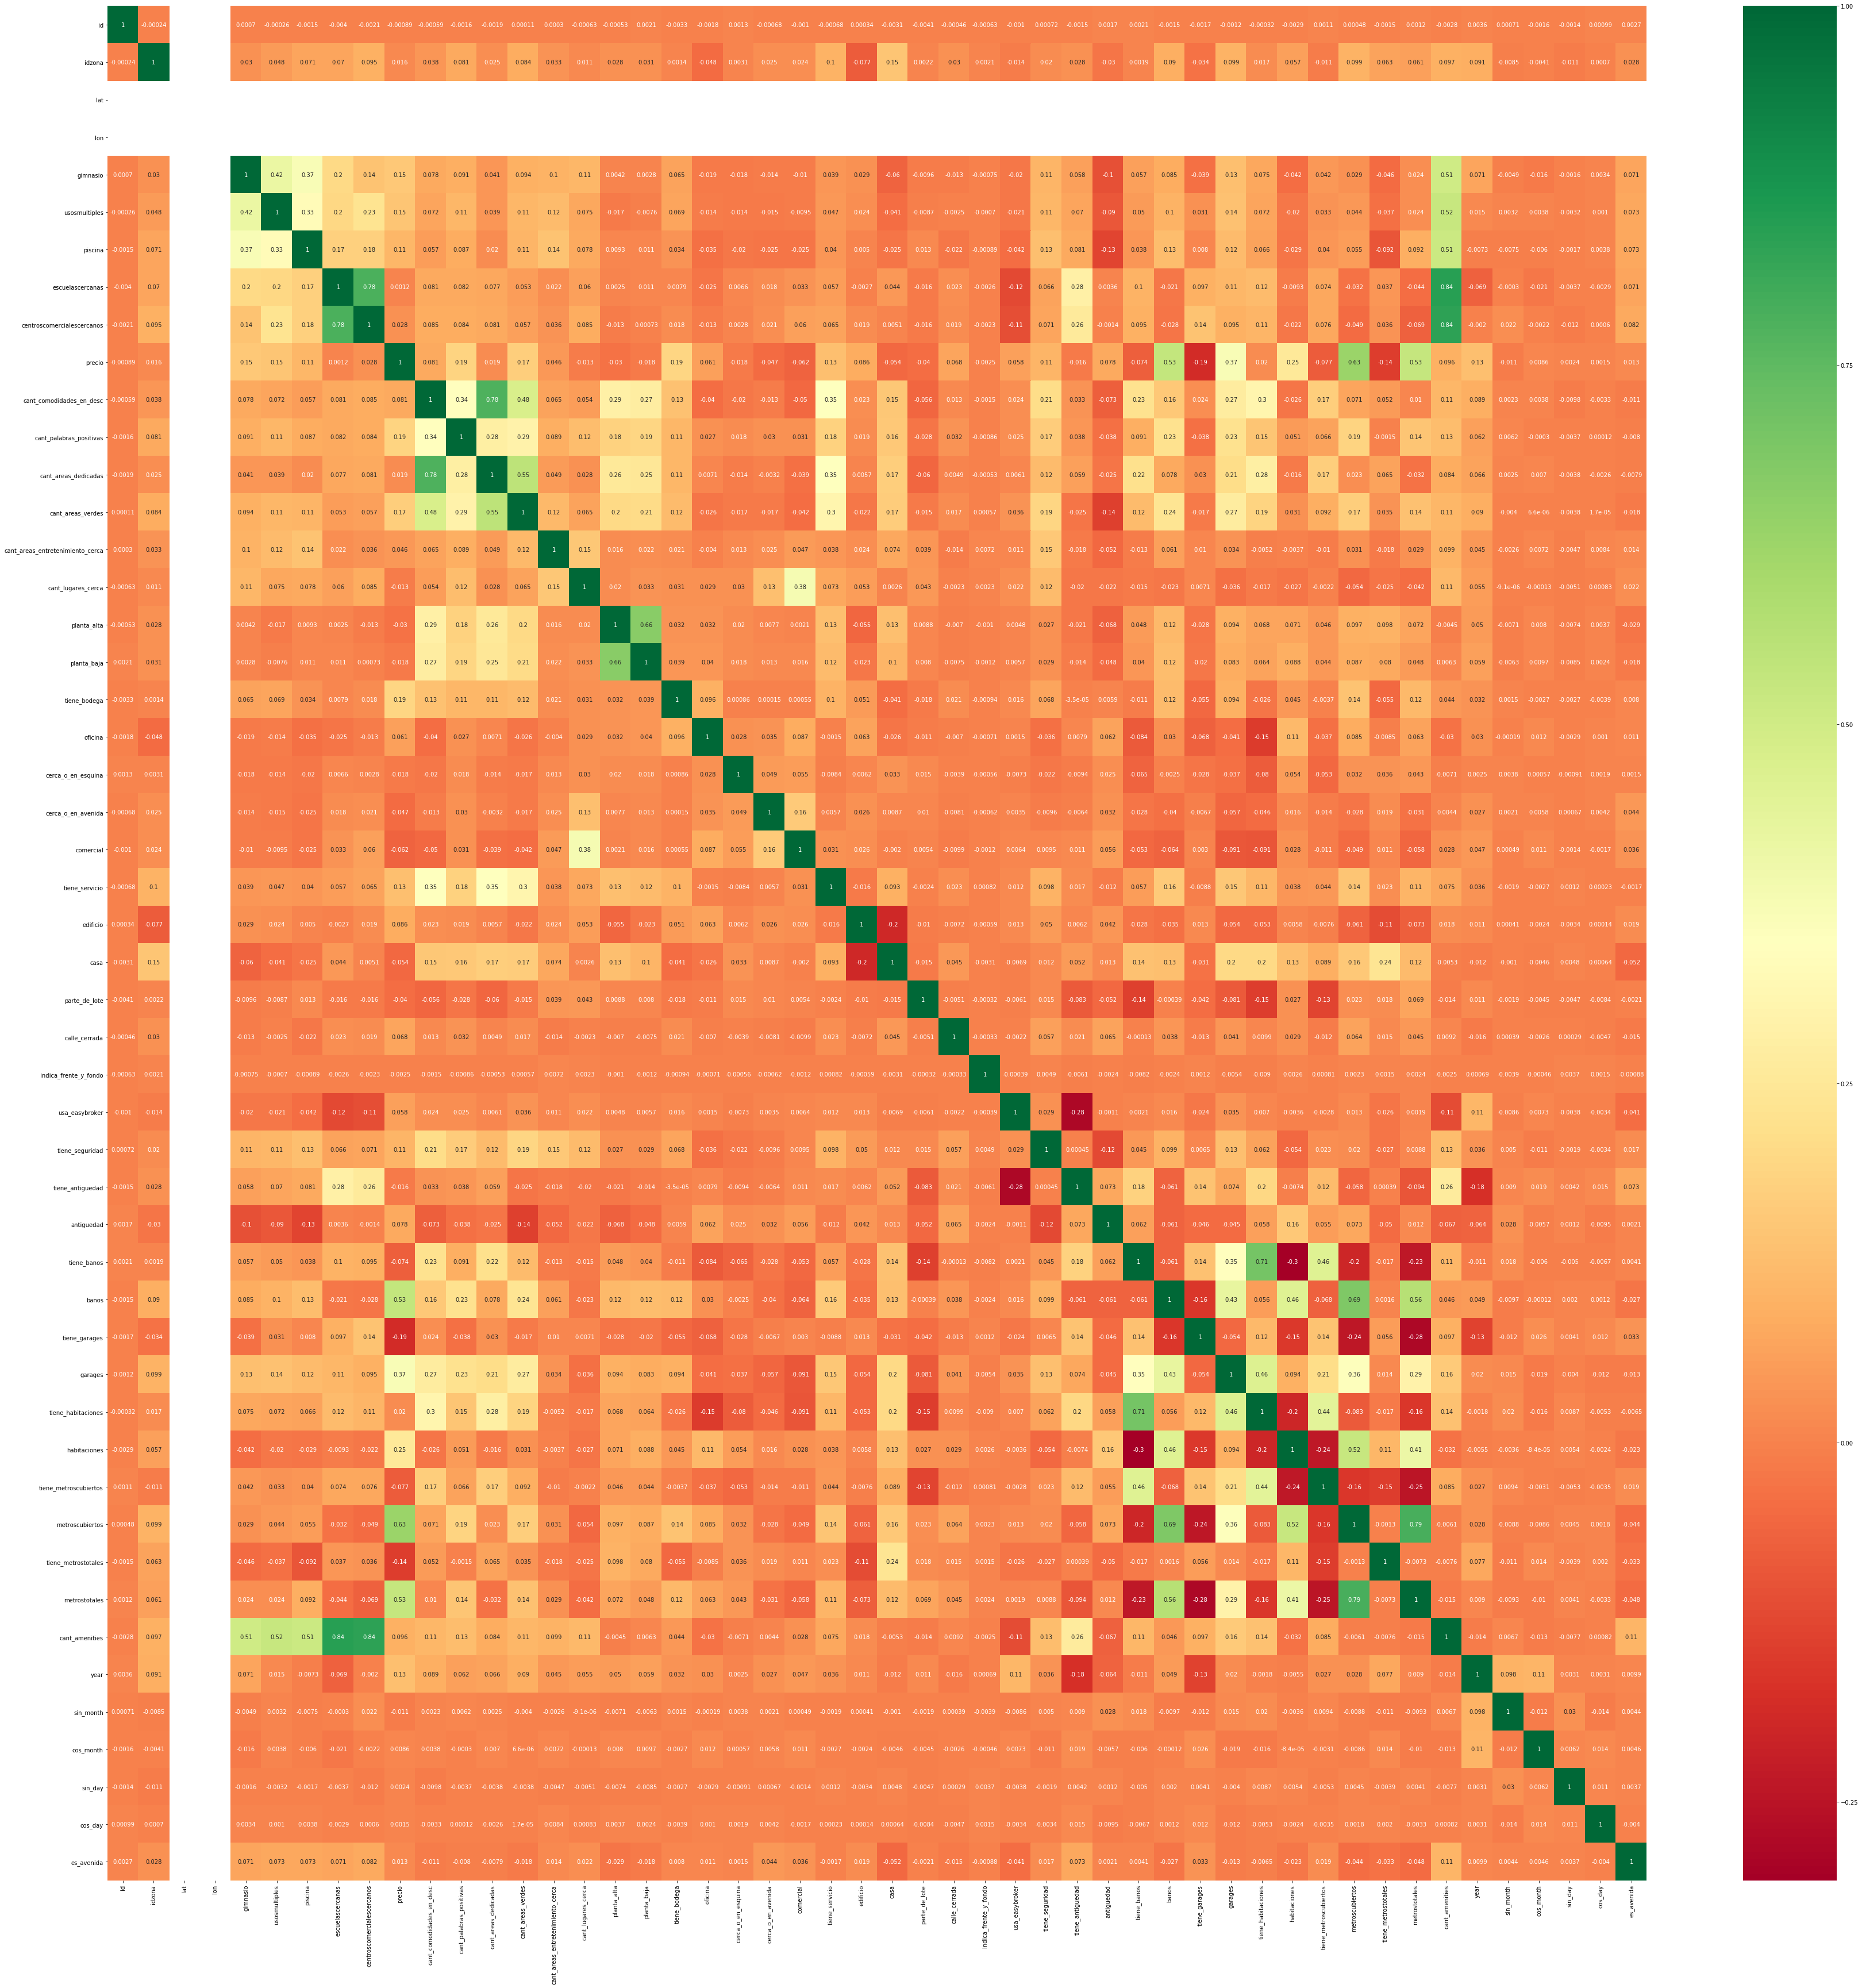

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

#get correlations of each features in dataset
corrmat = train.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(60,60))
#plot heat map
g=sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [30]:
figure = g.get_figure()    
figure.savefig('svm_conf.png', dpi=400)

#### Features algo de correlacion a la variable precio (mayores a 0.09)

- gimnasio
- usosmultiples
- piscina
- cant palabras positivas
- cant areas verdes
- tiene bodega
- tiene servicio
- tiene seguridad
- banos
- garages
- habitaciones
- metroscubiertos
- metros totales
- year
- cant amenities

### BoostARoota

In [18]:
# Define a seed, so all algorithms that accept a seed, take the same, for consistency reasons,
# so everything can be replicated without problems random state
seed=42

In [19]:
X = train.drop('precio', axis=1) #set de datos
y = train['precio'] #target

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

In [21]:
X_train = X_train.drop(['fecha','titulo', 'descripcion', 'direccion','idzona','lat','lon','ciudad','tipodepropiedad','provincia'],axis=1)

In [38]:
from boostaroota import BoostARoota
import pandas as pd

#Specify the evaluation metric: can use whichever you like as long as recognized by XGBoost
#EXCEPTION: multi-class currently only supports "mlogloss" so much be passed in as eval_metric
br = BoostARoota(metric='logloss')

#Fit the model for the subset of variables
br.fit(X_train, y_train) 

#Can look at the important variables - will return a pandas series
br.keep_vars_

Round:  1  iteration:  1
Round:  1  iteration:  2
Round:  1  iteration:  3
Round:  1  iteration:  4
Round:  1  iteration:  5
Round:  1  iteration:  6
Round:  1  iteration:  7
Round:  1  iteration:  8
Round:  1  iteration:  9
Round:  1  iteration:  10
BoostARoota ran successfully! Algorithm went through  1  rounds.


0                                   id
1                             gimnasio
2                        usosmultiples
3                              piscina
4                     escuelascercanas
5           centroscomercialescercanos
6             cant_comodidades_en_desc
7              cant_palabras_positivas
8                 cant_areas_dedicadas
9                    cant_areas_verdes
10    cant_areas_entretenimiento_cerca
11                  cant_lugares_cerca
12                         planta_alta
13                         planta_baja
14                        tiene_bodega
15                             oficina
16                  cerca_o_en_esquina
17                  cerca_o_en_avenida
18                           comercial
19                      tiene_servicio
20                            edificio
21                                casa
22                       parte_de_lote
23                       calle_cerrada
25                      usa_easybroker
26                     ti

In [43]:
X_train.columns.size

46

In [44]:
#Then modify dataframe to only include the important variables
br.transform(X_train).columns.size

45

### Mas restrictivo

In [24]:
from boostaroota import BoostARoota
import pandas as pd

#Specify the evaluation metric: can use whichever you like as long as recognized by XGBoost
#EXCEPTION: multi-class currently only supports "mlogloss" so much be passed in as eval_metric
br = BoostARoota(metric='logloss',cutoff=0.5,iters=50)

In [25]:
#Fit the model for the subset of variables
br.fit(X_train, y_train) 

#Can look at the important variables - will return a pandas series
br.keep_vars_

Round:  1  iteration:  1
Round:  1  iteration:  2
Round:  1  iteration:  3
Round:  1  iteration:  4
Round:  1  iteration:  5
Round:  1  iteration:  6
Round:  1  iteration:  7
Round:  1  iteration:  8
Round:  1  iteration:  9
Round:  1  iteration:  10
Round:  1  iteration:  11
Round:  1  iteration:  12
Round:  1  iteration:  13
Round:  1  iteration:  14
Round:  1  iteration:  15
Round:  1  iteration:  16
Round:  1  iteration:  17
Round:  1  iteration:  18
Round:  1  iteration:  19
Round:  1  iteration:  20
Round:  1  iteration:  21
Round:  1  iteration:  22
Round:  1  iteration:  23
Round:  1  iteration:  24
Round:  1  iteration:  25
Round:  1  iteration:  26
Round:  1  iteration:  27
Round:  1  iteration:  28
Round:  1  iteration:  29
Round:  1  iteration:  30
Round:  1  iteration:  31
Round:  1  iteration:  32
Round:  1  iteration:  33
Round:  1  iteration:  34
Round:  1  iteration:  35
Round:  1  iteration:  36
Round:  1  iteration:  37
Round:  1  iteration:  38
Round:  1  iteration:

0                             gimnasio
1                        usosmultiples
2           centroscomercialescercanos
3              cant_palabras_positivas
4                 cant_areas_dedicadas
5                    cant_areas_verdes
6     cant_areas_entretenimiento_cerca
7                          planta_alta
8                          planta_baja
9                         tiene_bodega
10                           comercial
11                      tiene_servicio
12                            edificio
13                                casa
14                      usa_easybroker
15                     tiene_seguridad
16                    tiene_antiguedad
17                          antiguedad
18                         tiene_banos
19                               banos
20                       tiene_garages
21                             garages
22                  tiene_habitaciones
23                        habitaciones
24               tiene_metroscubiertos
25                     me

### Asd

In [51]:
# Define a seed, so all algorithms that accept a seed, take the same, for consistency reasons,
# so everything can be replicated without problems random state
seed=42

In [57]:
X = train.drop('precio', axis=1) #set de datos
y = train['precio'] #target

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

In [59]:
X_train = X_train.drop(['fecha','titulo', 'descripcion', 'direccion','idzona','lat','lon','tipodepropiedad','ciudad','provincia'],axis=1)